## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

### Содержание

##### Часть 1. Подготовка данных:
* [1. Загрузка и первичное знакомство с данными. Проверка на монотонность.](#1)


##### Часть 2. Анализ:
* [1. Ресемплирование, тренды, сезонность.](#2)
* [2. Добавление новых признаков.](#3)


##### Часть 3. Анализ моделей:
* [1. Разделение датасета.](#4)
* [2. Константная модель. Проверка на адекватность.](#5)
* [3. Решающее дерево.](#6)
* [4. Модель CatBoost](#7)
* [5. Линейная регрессия.](#8)
* [6. Модель Lightgbm](#9)
##### Часть 4. Анализ результатов:
* [1. Составление датафрейма и построение графиков.](#10)
* [2. Вывод.](#11)

# 1. Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import datetime as dt


from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor

from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from catboost import Pool, CatBoostRegressor
from xgboost import XGBRegressor


<a id='1'></a>
### 1.1 Загрузка и знакомство с данными.

In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col='datetime')
print(df.info())
print(df.describe())
# Преобразуем тип данных индекса из 'object' в 'datetime64':
df.index = pd.to_datetime(df.index)
print('Данными охвачен временной интервал от: ', df.index.min(), 'до: ', df.index.max())

<class 'pandas.core.frame.DataFrame'>
Index: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0+ KB
None
         num_orders
count  26496.000000
mean      14.070463
std        9.211330
min        0.000000
25%        8.000000
50%       13.000000
75%       19.000000
max      119.000000
Данными охвачен временной интервал от:  2018-03-01 00:00:00 до:  2018-08-31 23:50:00


Имеем датафрейм с двумя колонками, 26496 записями - без пропусков.
Исходя из условия поставленной задачи целесообразно сразу взять в качестве индексов колонку 'datetime'.

In [3]:
# Взглянем на данные
df.head(3)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28


In [4]:
# Проверка на монотонность
df.sort_index(inplace=True)
df.index.is_monotonic

True

На всякий случай отсортируем данные и выполним проверку на монотонность, удостоверившись что в данных нет пропусков по времени.

# 2. Анализ

<a id='2'></a>
### 2.1 Ресемплирование, тренды, сезонность.

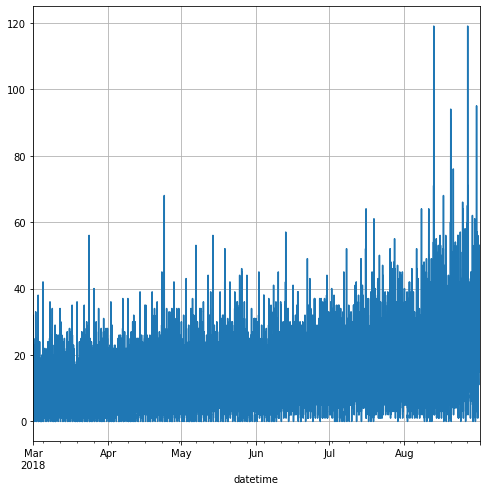

In [5]:
df.num_orders.plot(figsize=[8,8], grid=True)

Это мало похоже на комедию.. Проведем ресемплирование..

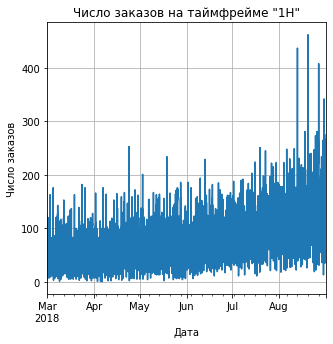

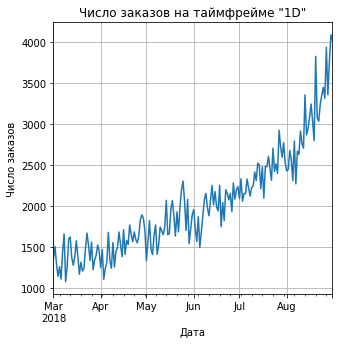

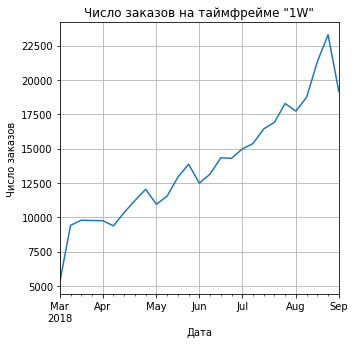

In [6]:
# Чтобы автоматизировать процес переключения между таймфреймами, напишем функцию:
def resplot(data, timeframe):

    """Функция принимает на вход датафрейм и временной интервал в формате string 
    и выводит график ресемплированных на заданном временном интервале данных. 
    """

    data.num_orders.resample(timeframe).sum().plot(figsize=[5,5], grid=True)
    plt.ylabel('Число заказов')
    plt.xlabel('Дата')
    plt.title('Число заказов на таймфрейме "{}"'.format(timeframe))
    plt.show()

    return 

# Посмотрим как выглядят данные о количестве заказов на различных таймфреймах:

for TF in ['1H', '1D', '1W']:
    resplot(df, TF)

# Запишем сгруппированные по часам данные в новый датафрейм:
df_1D = df.resample('1D').sum()
df_1H = df.resample('1H').sum()

Чем больше таймфрейм, тем очевиднее восходящий тренд. Само по себе его наличие, по всей видимости, связано с особенностями нашей выборки - весной как раз начинается период отпусков, когда нагрузка на транспортную инфраструктуру увеличивается. Дополнительным подтверждением нашего предположения служит значительное снижение числа заказов на последних неделях лета. 

Наиболее информативным представляется дневной таймфрейм. Остальные слишком сильно сглажены. Его и выберем в качестве основного для дальнейшего анализа.

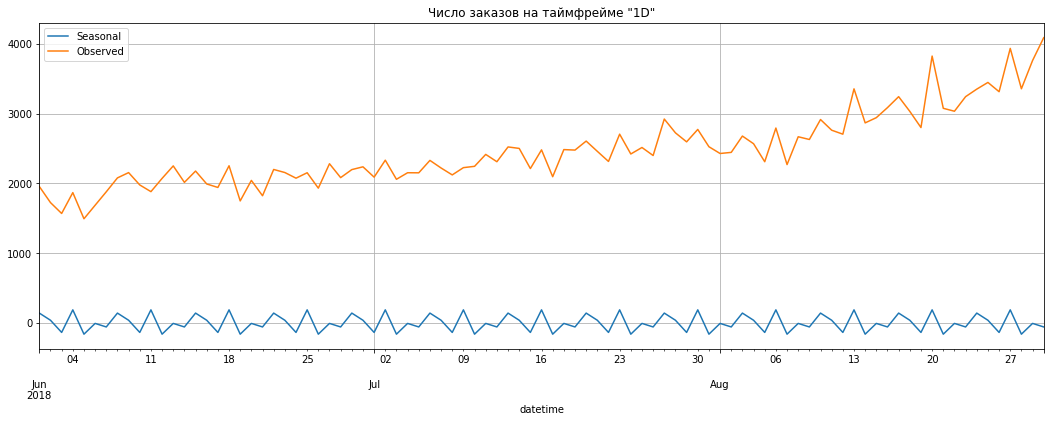

In [7]:
df.dropna(inplace=True)
df.shape

decomposed = seasonal_decompose(df_1D['2018-06-01':'2018-08-30'])

plt.title('Число заказов на таймфрейме "1D"')
decomposed.seasonal.plot(ax=plt.gca(), figsize=[18,6], grid=True)
decomposed.observed.plot(ax=plt.gca(), figsize=[18,6], grid=True)
L=plt.legend()
L.get_texts()[0].set_text('Seasonal')
L.get_texts()[1].set_text('Observed')


Очистив данные от шума, замечаем некоторую цикличность изменений числа заказов внутри недели (синяя кривая) Минимумов "очищенной" функции приходится четыре на месяц - это четыре вечера понедельника.

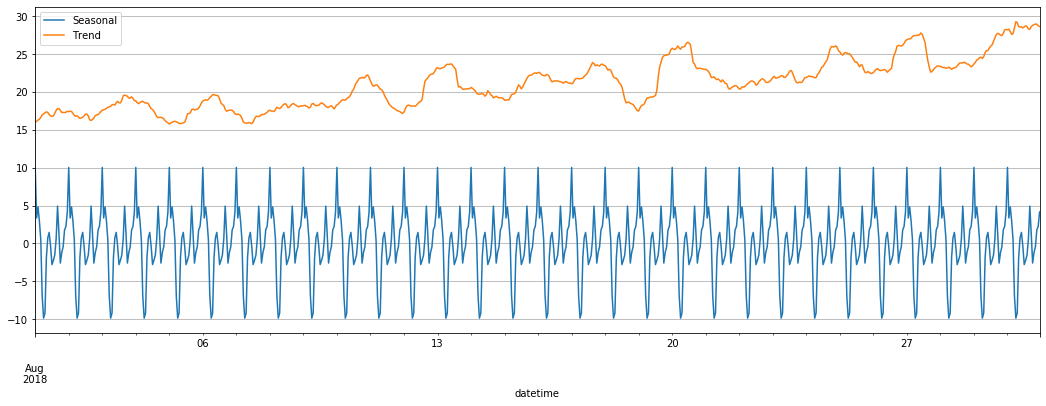

In [8]:
# Рассмотрим те же данные на младшем таймфрейме и более коротком временном интервале:
decomposed = seasonal_decompose(df.resample('1H').mean())
decomposed.seasonal['2018-08-01':'2018-08-30'].plot(ax=plt.gca(), figsize=[18,6], grid=True)
decomposed.trend['2018-08-01':'2018-08-30'].plot(ax=plt.gca(), figsize=[18,6], grid=True)
L=plt.legend()
L.get_texts()[0].set_text('Seasonal')
L.get_texts()[1].set_text('Trend')


Помимо циклов внутри дня (нижняя кривая) мы так же можем наблюдать и циклы внутри недели, но уже в виде отфильтрованных трендов на верхнем графике ('Trend').
Внутри дня провал по числу заказов наблюдается в период глубокой ночи, а самый пик - вечером. Звучит резонно.
В недельных циклах можно заметить два всплеска - один связан с субботой, другой - с понедельником. Люди уезжают на выходные и возвращаются обратно к началу рабочей недели. 
Если посмотреть по весенним месяцам, там эти недельные циклы не выглядят так чётко - всему виной праздничные выходные дни. В самом датафрейме не содержится информации о праздничных днях, нам предстоит ее внести, воспользовавшись производственным календарём за 2018 год.

<a id='3'></a>
### 2.2 Добавление новых признаков.

In [9]:
# Составим список праздничных выходных дней согласно производственному календарю за 2018 год:
holidays = pd.to_datetime(['2018-03-08', '2018-03-09', '2018-04-30', '2018-05-01', '2018-05-02', '2018-05-09', '2018-06-11', '2018-06-12'])

# Проверим, входит ли день в список праздничных выходных дней, если входит - назначим новому признаку 'is_holiday' значение 1, если нет - 0. 
df_1H['Date'] = df_1H.index.strftime('%Y-%m-%d')
df_1H['is_holiday'] = df_1H['Date'].apply(lambda i : 1 if i in holidays else 0)
df_1H.drop(columns=['Date'], inplace=True)


Приступим к добавлению новых признаков, необходимых для обучения модели. Первым делом добавим праздничные дни - категориальный признак со значениями "1" - да, "0" - нет. 
Составим словарь праздничных дней и, при помощи лямбда-функции, проверим индекс каждого объекта в выборке на вхождение в этот словарь. 
Поскольку формат индекса включал в себя так же и время, пришлось создать временный признак 'Date', а после обработки датафрейма удалить его. Выглядит кринжово, но работает.

In [10]:

# Проверим длину датафрейма перед добавлением новых фич:
print(df_1H.shape)
# Начинаем декомпозировать с 49 индекса, поскольку раньше произвести эти вычисления невозможно:
df_1H_index_list = df_1H.index.strftime('%Y-%m-%d, %H:%M:%S').to_list()[48:]

# 
seasonal_decompose(df_1H.num_orders[df_1H.index < '2018-03-03 01:00:00']).trend['2018-03-03 00:00:00']


historical_seasonal = [np.NaN]*49+[seasonal_decompose(df_1H.num_orders[df_1H.index < 
                                     df_1H_index_list[i]], model='additive').seasonal[df_1H_index_list[i-1]] 
                                     for i in range(1, len(df_1H_index_list))]

(4416, 2)


На следующем этапе идёт добавление данных о сезонности. Здесь важно избежать "заглядывания вперед", и для каждого шага высчитывать метрику только на имеющихся на момент совершения этого шага данных. Для этого отфильтровываем датафрейм по индексу обрабатываемого объекта, декомпостируем данные и заполняем ячейку последним актуальным значением. 
Для использования функции "seasonal_decompose" необходимо минимум 48 шагов, две полных суточных цикла данных. Соответственно, первое значение мы получим только на 49 индексе.

Кажется, "заглядывания в будущее" удалось избежать.

Добавить таким же образом данные о тренде и "остаток", увы, не удалось. Функция выдаёт лист NaN, как ни сдвигай начальный индекс вперёд. Да данный момент решение мной не найдено, работаем с тем что есть.

In [11]:
# Проверим вручную пару значений из нашей новой фичи:
# print(seasonal_decompose(df_1H.num_orders[df_1H.index < '2018-03-03 05:00:00']).seasonal['2018-03-03 04:00:00'])

# Добавим лист в датафрейм в качестве новой колонки:

df_1H['season_historical'] = pd.Series(data=historical_seasonal, index=df_1H.index)

In [12]:
# Функция, создающая фичи:

def features_creator(data):

#     data['month'] =  data.index.month
  
    data['dow'] =  data.index.dayofweek

    data['hour'] = data.index.hour

    data['rolling_mean'] = data.num_orders.shift(1).rolling(12).mean()  
    
    for i in range(1,169):
        data['lag_{}'.format(i)] = data.num_orders.shift(i)

    return data




В довершение нашей предобработки добавим наиболее очевидные признаки - такие как номер месяца, день недели, час, значение скользящей средней за предыдущие 12 значений (на момент t данные за t-1 у нас имеются, и мы можем ими воспользоваться).

In [13]:
# Применим функцию, удалим NaN, взглянем на датафрейм перед разделением его на признаки:
df_1H = features_creator(df_1H)
df_1H.dropna(inplace=True)

df_1H.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4248 entries, 2018-03-08 00:00:00 to 2018-08-31 23:00:00
Freq: H
Columns: 174 entries, num_orders to lag_168
dtypes: float64(170), int64(4)
memory usage: 5.7 MB


Итоговый размер выборки - осталось 4248 из 4416 объектов. Потери приемлемые.

# 3. Обучение и тест

<a id='4'></a>
### 3.1 Разделение датасета

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df_1H.drop(columns=['num_orders']), df_1H['num_orders'], test_size=0.1, shuffle=False)

In [15]:
X_test

,is_holiday,season_historical,dow,hour,rolling_mean,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_159,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-14 07:00:00,0,-55.462350,1,7,122.500000,45.0,47.0,139.0,190.0,108.0,...,99.0,111.0,74.0,100.0,115.0,71.0,99.0,120.0,79.0,44.0
2018-08-14 08:00:00,0,-50.968629,1,8,119.416667,54.0,45.0,47.0,139.0,190.0,...,101.0,99.0,111.0,74.0,100.0,115.0,71.0,99.0,120.0,79.0
2018-08-14 09:00:00,0,-10.045775,1,9,120.166667,91.0,54.0,45.0,47.0,139.0,...,84.0,101.0,99.0,111.0,74.0,100.0,115.0,71.0,99.0,120.0
2018-08-14 10:00:00,0,3.175286,1,10,118.083333,135.0,91.0,54.0,45.0,47.0,...,89.0,84.0,101.0,99.0,111.0,74.0,100.0,115.0,71.0,99.0
2018-08-14 11:00:00,0,7.881936,1,11,122.333333,155.0,135.0,91.0,54.0,45.0,...,87.0,89.0,84.0,101.0,99.0,111.0,74.0,100.0,115.0,71.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,0,-15.526351,4,19,163.416667,207.0,217.0,197.0,116.0,133.0,...,196.0,187.0,160.0,246.0,273.0,173.0,242.0,166.0,179.0,113.0
2018-08-31 20:00:00,0,-7.107760,4,20,170.916667,136.0,207.0,217.0,197.0,116.0,...,118.0,196.0,187.0,160.0,246.0,273.0,173.0,242.0,166.0,179.0
2018-08-31 21:00:00,0,-2.685872,4,21,168.583333,154.0,136.0,207.0,217.0,197.0,...,74.0,118.0,196.0,187.0,160.0,246.0,273.0,173.0,242.0,166.0


<a id='5'></a>
### 3.2 Константная модель

In [16]:
# Для начала создадим константную модель, с которой будем сравнивать все прочие модели:
const_pred = np.ones(len(y_test))*y_train.mean()
print('RMSE константной модели:', mean_squared_error(y_test, const_pred)**0.5)

RMSE константной модели: 84.45113423436631


<a id='6'></a>
### 3.3 Случайный лес

In [17]:
# %%time
# # Подберём гиперпараметры для модели "случайный лес":


# model = RandomForestRegressor(random_state=123, n_jobs=-1, criterion='mse')



    
# rfr_params = {'n_estimators': range(1,120,3), 
#                   'max_depth': range(1,60,2),
#                   'min_samples_split': range(2,40,1),
#                   'min_samples_leaf': range(2,40,1),
                  
                  
                  
#                   }



# rfr_cv = RandomizedSearchCV(
#             estimator=model,
#             param_distributions=rfr_params,
#             scoring='neg_mean_squared_error',
#             return_train_score=True,
            
                           
#                            )

# rfr_cv.fit(X_train, y_train)
# print(rfr_cv.best_params_)

In [18]:
%%time

# Обучим случайный лес:

rfr = RandomForestRegressor(
                            n_estimators=103,
                            min_samples_split=14,
                            min_samples_leaf=8,
                            max_depth=23,
#                              **rfr_cv.best_params_,
                            random_state=123,)

rfr.fit(X_train, y_train)

rfr_pred = rfr.predict(X_test)
print('RMSE решающего леса на тестовой выборке:', mean_squared_error(y_test, rfr_pred)**0.5)

RMSE решающего леса на тестовой выборке: 39.033059465067275
CPU times: user 24.3 s, sys: 7.26 ms, total: 24.3 s
Wall time: 24.8 s


<a id='7'></a>
### 3.4 CatBoost

In [24]:
%%time

# Обучим CatBoost:

cbr = CatBoostRegressor(learning_rate=0.11,
                        
    verbose=100,
    
    )

cbr.fit(X_train, y_train, cat_features=[0,2])

cbr_pred = cbr.predict(X_test)
print('RMSE котобуста на тестовой выборке:', mean_squared_error(y_test, cbr_pred)**0.5)

0:	learn: 36.6450078	total: 65.9ms	remaining: 1m 5s
100:	learn: 17.6590019	total: 10.9s	remaining: 1m 37s
200:	learn: 14.5002230	total: 21.8s	remaining: 1m 26s
300:	learn: 12.2163645	total: 32.7s	remaining: 1m 15s
400:	learn: 10.2729000	total: 43.8s	remaining: 1m 5s
500:	learn: 8.5966961	total: 56s	remaining: 55.8s
600:	learn: 7.2390138	total: 1m 8s	remaining: 45.4s
700:	learn: 6.0756089	total: 1m 20s	remaining: 34.5s
800:	learn: 5.1408169	total: 1m 32s	remaining: 23.1s
900:	learn: 4.3901516	total: 1m 45s	remaining: 11.6s
999:	learn: 3.7686763	total: 1m 57s	remaining: 0us
RMSE котобуста на тестовой выборке: 36.68669343950008
CPU times: user 1min 49s, sys: 8.45 s, total: 1min 58s
Wall time: 2min


Присвоение признакам 'is_holiday', 'dow' статус категориальных при помощи параметра cat_features значительно улучшило метрику.

<a id='8'></a>
### 3.5 Линейная регрессия

In [25]:
%%time

# Обучим линейную регрессию:

lir = LinearRegression(fit_intercept=True, normalize=True)

lir.fit(X_train, y_train)

lir_pred = lir.predict(X_test)
print('RMSE линейной регрессии на тестовой выборке:', mean_squared_error(y_test, lir_pred)**0.5)



RMSE линейной регрессии на тестовой выборке: 34.231898172706316
CPU times: user 703 ms, sys: 704 ms, total: 1.41 s
Wall time: 1.4 s


<a id='9'></a>
### 3.6 Lightgbm

In [26]:
# %%time
# # Осуществляем подбор гиперпараметров для lightgbm:

# model = lgb.LGBMRegressor()


# params ={
    
#     'num_leaves': range(1, 100),
#     'learning_rate':[0+(i*0.02) for i in range(1, 50)],
#     'subsample':[1],
#     'n_estimators': range(1, 100),
#     'max_depth': range(5, 50)
# }

# lgmb_grid = RandomizedSearchCV(
#     estimator=model,
#     param_distributions=params,
#     scoring='neg_mean_squared_error',
#     return_train_score=True,
    

# )

# lgmb_grid.fit(X_train, y_train)
# print(lgmb_grid.best_params_)

In [27]:
%%time

# Обучим Lightgbm:


gbm = lgb.LGBMRegressor(
#                         **lgmb_grid.best_params_,
                        
                       n_estimators=200,
                        num_leaves=31,
                        max_depth=45,
                        learning_rate=0.13,
                       boosting_type='gbdt',
                       n_jobs=-1,
                       )



gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='rmse',
        early_stopping_rounds=5)



gbm_pred = gbm.predict(X_test)


# Выведем метрику качества и запишем ее в соответствующий лист:
print('RMSE на тестовой выборке для Lightgbm: ', (mean_squared_error(y_test, gbm_pred))**0.5)


[1]	valid_0's rmse: 77.2237	valid_0's l2: 5963.5
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 71.8577	valid_0's l2: 5163.53
[3]	valid_0's rmse: 66.8855	valid_0's l2: 4473.67
[4]	valid_0's rmse: 62.5087	valid_0's l2: 3907.34
[5]	valid_0's rmse: 58.6038	valid_0's l2: 3434.4
[6]	valid_0's rmse: 55.7771	valid_0's l2: 3111.08
[7]	valid_0's rmse: 52.8383	valid_0's l2: 2791.88
[8]	valid_0's rmse: 50.6055	valid_0's l2: 2560.92
[9]	valid_0's rmse: 48.7594	valid_0's l2: 2377.48
[10]	valid_0's rmse: 47.0963	valid_0's l2: 2218.06
[11]	valid_0's rmse: 45.8243	valid_0's l2: 2099.87
[12]	valid_0's rmse: 44.4119	valid_0's l2: 1972.42
[13]	valid_0's rmse: 43.2325	valid_0's l2: 1869.05
[14]	valid_0's rmse: 42.3887	valid_0's l2: 1796.81
[15]	valid_0's rmse: 41.4482	valid_0's l2: 1717.96
[16]	valid_0's rmse: 40.5224	valid_0's l2: 1642.06
[17]	valid_0's rmse: 39.9379	valid_0's l2: 1595.04
[18]	valid_0's rmse: 39.3245	valid_0's l2: 1546.42
[19]	valid_0's rmse: 39.071	valid

# 4. Анализ

<a id='10'></a>
### 4.1 Сравнение прогнозов. Графики.

RMSE на тестовой выборке для Случайный лес: 39.033059465067275


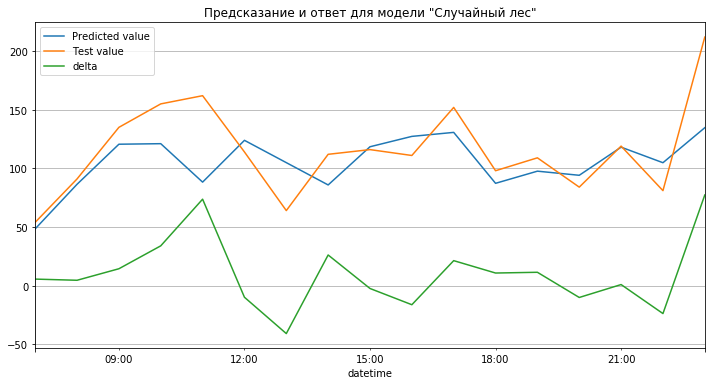

RMSE на тестовой выборке для CatBoost: 36.68669343950008


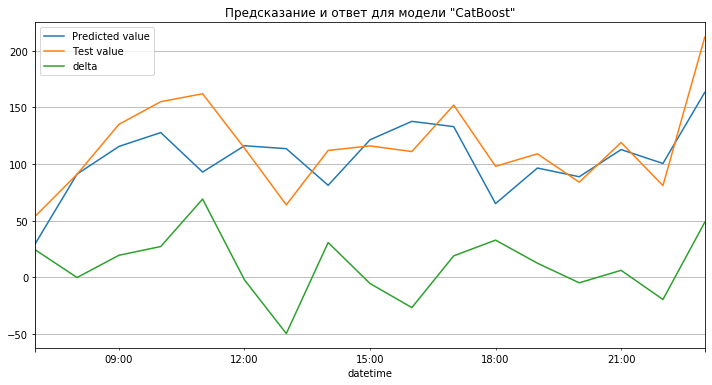

RMSE на тестовой выборке для Линейной регрессии: 34.231898172706316


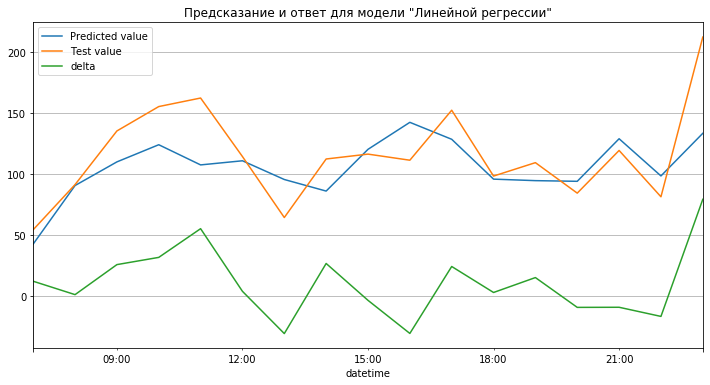

RMSE на тестовой выборке для Lightgbm: 36.59495747049304


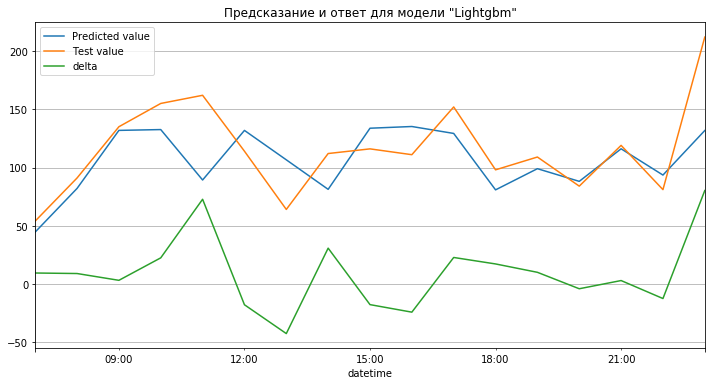

In [28]:

def forecast_comparison(y_test, prediction, index, model_name):

    """Функция принимает на вход предсказания и ответы, и строит на этой основе графики.
      y_test - вектор ответов
      prediction - вектор предсказаний
      index - список индексов для создания DataFrame
      model_name - имя модели в формате string
      """
    comparison_data = pd.DataFrame({'Predicted value': prediction, 'Test value': y_test}, index=index)
    comparison_data['delta'] = comparison_data['Test value'] - comparison_data['Predicted value']
    comparison_data['2018-08-01 00:00:00':'2018-08-14 23:00:00'].plot(figsize=[12,6], grid=True)

    plt.title('Предсказание и ответ для модели "{}"'.format(model_name))
    print('RMSE на тестовой выборке для {}:'.format(model_name), (mean_squared_error(y_test, prediction))**0.5)
    plt.show()


    return 
forecast_comparison(y_test, rfr_pred, X_test.index, 'Случайный лес')
forecast_comparison(y_test, cbr_pred, X_test.index, 'CatBoost')
forecast_comparison(y_test, lir_pred, X_test.index, 'Линейной регрессии')
forecast_comparison(y_test, gbm_pred, X_test.index, 'Lightgbm')


<a id='11'></a>
### Вывод

Нами было проведено исследование исторических данных о заказах такси в аэропортах. Были выявлены циклические колебания как внутри дня, так и в недельных циклах. А так же растущий тренд на совершение переездов в рамках изучаемого датасета.

Были созданы модели, предсказывающие количество заказов на следующий час, исходя из календарного месяца, дня недели, времени суток и того, является ли день праздничным выходным. Мы с запасом уложились в заданный по ТЗ допуск по метрике точности RMSE - 34.23 против максимально допустимого значения 48. 

Наилучшую точность показала модель линейной регрессии, так же хороший результат приносят Lightgbm и Catboost. Наихудшая точность у модели случайный лес. Все без исключения модели прошли проверку на адекватность, вдвое превзойдя константную модель по точности прогноза.  


В процессе выполнения работы нами были опробованы такие методы преобразования данных как ресэмплирование, разложение на сезонные линии и линии тренда. 

Ошибкой, которой при работе со временными рядами следует опасаться, является "look-forward bias" - вычисление каких-либо признаков по таким данным, которых модель в действительности на момент вычисления иметь не может, "просачивание" таргета в обучающие признаки со всеми вытекающими из этого последствиями.

